In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from math import sqrt
import seaborn as sns
from scipy import stats

In [21]:
# read the data
df=pd.read_csv('song_data.csv')
df_info=pd.read_csv('song_info.csv')
#remove the duplicates
df = df.drop_duplicates(subset=['song_name'])

# Join the categorical variables
names=df_info['artist_name']
playlist = df_info['playlist']
album = df_info['album_names']
df = df.join(names)
df = df.join(playlist)
df = df.join(album)

In [3]:
#delete records with popularity equal to zero (wrong values)
index_delete = df.index[df['song_popularity']==0]
df = df.drop(index_delete)

#check that there is no null value
df.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
artist_name         0
playlist            0
album_names         0
dtype: int64

In [4]:
leble_en=preprocessing.LabelEncoder()
df['artist_name']=leble_en.fit_transform(df['artist_name'])
df['playlist']=leble_en.fit_transform(df['playlist'])
df['album_names']=leble_en.fit_transform(df['album_names'])

In [25]:
dff=pd.get_dummies(data=df,columns=['time_signature'])

dff.head

<bound method NDFrame.head of                         song_name  song_popularity  song_duration_ms  \
0      Boulevard of Broken Dreams               73            262333   
1                      In The End               66            216933   
2               Seven Nation Army               76            231733   
3                      By The Way               74            216933   
4               How You Remind Me               56            223826   
...                           ...              ...               ...   
18827                  Stay Awake               55            114582   
18830              Let It Breathe               60            159645   
18832      Sudden Love (Acoustic)               23            182211   
18833           Gentle on My Mind               55            352280   
18834                    Up to Me               60            193533   

       acousticness  danceability  energy  instrumentalness  key  liveness  \
0          0.005520        

In [27]:
print(type(df))  # This should output <class 'pandas.core.frame.DataFrame'>  


<class 'pandas.core.frame.DataFrame'>


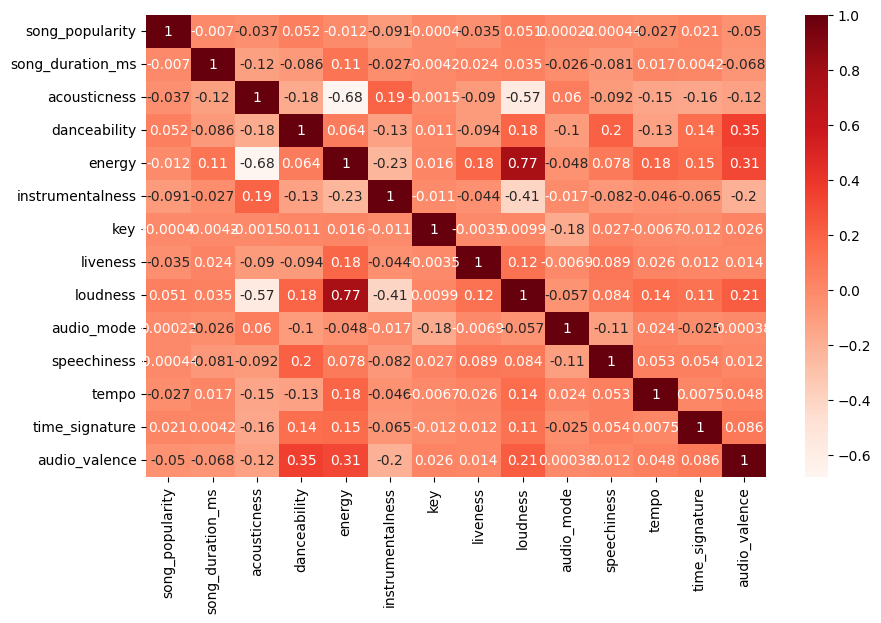

In [29]:
# Filter numeric columns for correlation  
numeric_df = df.select_dtypes(include=['float64', 'int64'])  

# Calculate the correlation matrix if any numeric data exists  
if not numeric_df.empty:  
    cor = numeric_df.corr()  
    
    # Create a heatmap  
    f, ax = plt.subplots(figsize=(10, 6))  
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, ax=ax)  
    plt.show()  
else:  
    print("No numeric data available for correlation.")  

In [30]:
# remove the features 
df = df.drop(['song_name','audio_mode','key','speechiness','album_names','song_duration_ms','energy'],axis=1)

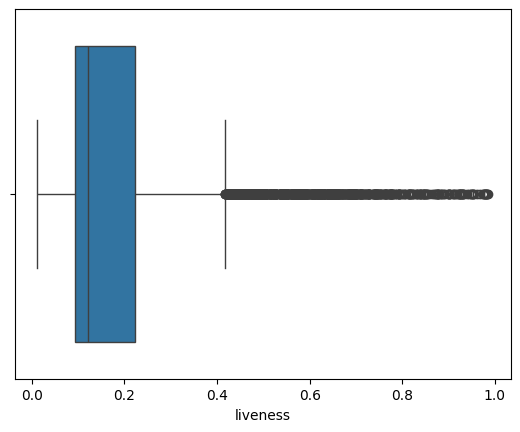

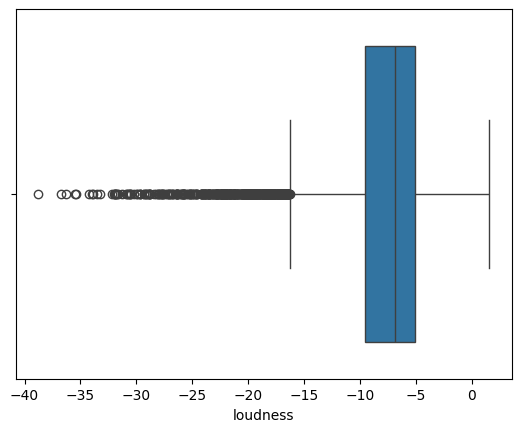

In [31]:
sns.boxplot(x=df['liveness'])
plt.show()
sns.boxplot(x=df['loudness'])
plt.show()

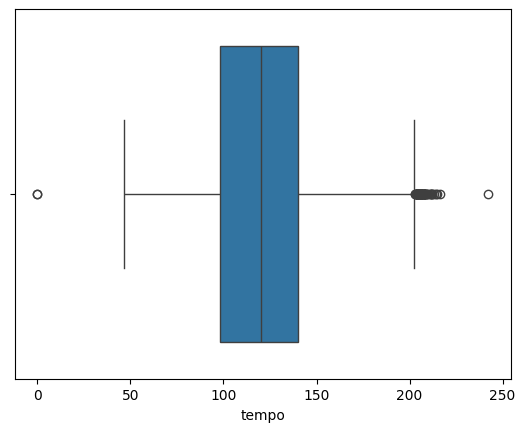

In [32]:
sns.boxplot(x=df['tempo'])
plt.show()

index_delete = df.index[df['tempo']==0]
df = df.drop(index_delete)

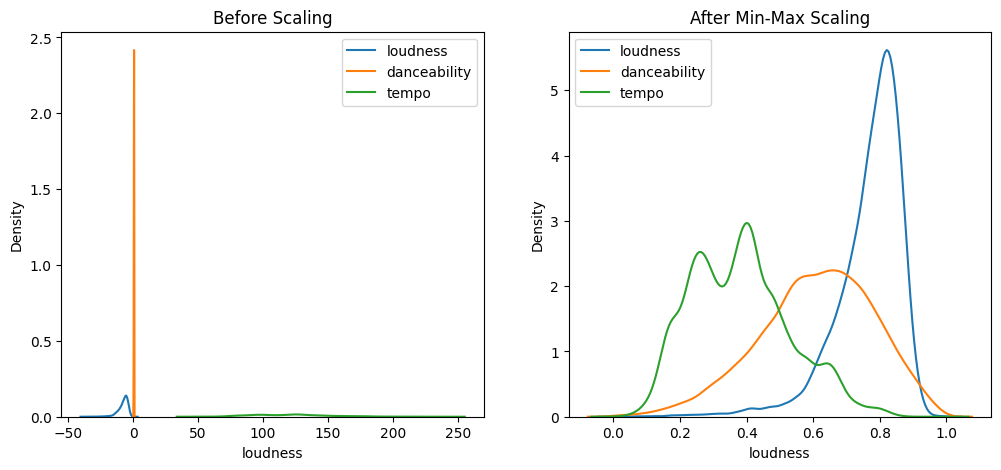

In [34]:
# Select numeric columns for scaling  
numeric_df = df.select_dtypes(include=['float64', 'int64'])  

# Initialize the MinMaxScaler  
scaler = preprocessing.MinMaxScaler()  

# Fit and transform the numeric data  
df_scaled = scaler.fit_transform(numeric_df)  

# Create a new DataFrame with scaled data  
df_scal = pd.DataFrame(df_scaled, columns=numeric_df.columns)  

# Visualizing before and after scaling  
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))  

ax1.set_title('Before Scaling')  
sns.kdeplot(df['loudness'], ax=ax1, label='loudness')  
sns.kdeplot(df['danceability'], ax=ax1, label='danceability')  
sns.kdeplot(df['tempo'], ax=ax1, label='tempo')  
ax1.legend()  

ax2.set_title('After Min-Max Scaling')  
sns.kdeplot(df_scal['loudness'], ax=ax2, label='loudness')  
sns.kdeplot(df_scal['danceability'], ax=ax2, label='danceability')  
sns.kdeplot(df_scal['tempo'], ax=ax2, label='tempo')  
ax2.legend()  

plt.show()  

In [35]:
# separate the target
x=df_scal.drop(['song_popularity'],axis=1)
y=df_scal['song_popularity']

# train, validation and test
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=20)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.20,random_state=20)

# range of the Hyperparameters
max_depth=[5,20, 50, 90]
min_samples_leaf = [1, 3, 5]
min_samples_split = [2, 6, 12]
# range of the parameter for the number of trees
n_estimators = [100,300,500]

best_err = 1
for num in n_estimators:
    for min_split in min_samples_split:
        for min_leaf in min_samples_leaf:
            for depth in max_depth:
                rf=RandomForestRegressor(n_estimators=num,max_depth=depth,max_features='sqrt',min_samples_leaf=min_leaf,min_samples_split=min_split, random_state=42)
                rf.fit(x_train,y_train)
                prediction=rf.predict(x_val)
                err = sqrt(metrics.mean_squared_error(y_val, prediction))
                if(err < best_err):
                    best_err = err
                    best_num = num
                    best_split = min_split
                    best_leaf = min_leaf
                    best_depth = depth
rf

RandomForestRegressor(max_depth=90, max_features='sqrt', min_samples_leaf=5,
                      min_samples_split=12, n_estimators=500, random_state=42)

In [38]:
new_x_train = pd.concat([x_train, x_val], ignore_index=True)  
new_y_train = pd.concat([y_train, y_val], ignore_index=True)

randomForest = RandomForestRegressor(n_estimators=best_num,max_depth=best_depth,max_features='sqrt',min_samples_leaf=best_leaf,min_samples_split=best_split, random_state=42)
randomForest.fit(new_x_train, new_y_train)
test_prediction = randomForest.predict(x_test)

print('Root Mean Squared Error:', sqrt(metrics.mean_squared_error(y_test, test_prediction)))

Root Mean Squared Error: 0.19832515572273887
